In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from tqdm import tqdm
import albumentations as A
import shutil
from datetime import datetime
from time import time
from sklearn.model_selection import train_test_split
#from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "True"
    os.environ["TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS"] = "True"

seed_everything()
warnings.filterwarnings('ignore')

TensorFlow Version 2.6.4


In [2]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'} 


In [3]:
df = pd.DataFrame(columns =['class', 'directory'])  
for path, names, filenames in os.walk('/kaggle/input/covid19-chest-xray-dataset/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal'):
    for filename in filenames:
        df.loc[-1] = ["normal", ('normal/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for path, names, filenames in os.walk('/kaggle/input/covid19-chest-xray-dataset/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid'):
    for filename in filenames:
        df.loc[-1] = ["covid", ('covid/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for path, names, filenames in os.walk('/kaggle/input/covid19-chest-xray-dataset/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia'):
    for filename in filenames:
        df.loc[-1] = ["pneumonia", ('pneumonia/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index()

In [4]:
df

,class,directory
0,pneumonia,pneumonia/person861_virus_1506.jpeg
1,pneumonia,pneumonia/person799_virus_1431.jpeg
2,pneumonia,pneumonia/person652_bacteria_2544.jpeg
3,pneumonia,pneumonia/person1408_virus_2411.jpeg
4,pneumonia,pneumonia/person124_virus_231.jpeg
...,...,...
4570,normal,normal/00000259_000.png
4571,normal,normal/00000916_000.png
4572,normal,normal/00000315_004.png
4573,normal,normal/00000618_000.png


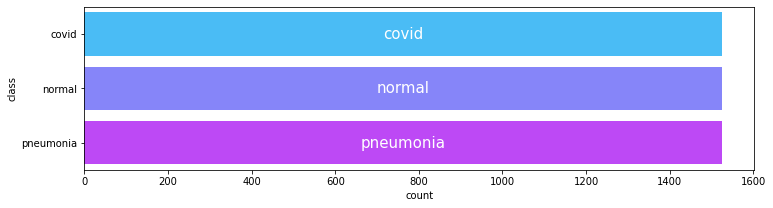

In [5]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='class'), y ='class', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['covid', 'normal', 'pneumonia'], 
              label_type='center', size=15, color='w')
plt.show()

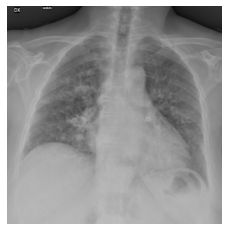

Image Shape: (1083, 1068, 3)
Image Height: 1083
Image Width: 1068
Image Dimension: 3
Image Size: 3388kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


In [7]:
plt.figure()
image = cv2.imread("/kaggle/input/covid19-chest-xray-dataset/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg")
plt.imshow(image)
plt.axis('off')
plt.show() 

print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df['directory'], df['class'], stratify= df['class'], test_size=0.20, random_state=1)

In [9]:
print(f"""
{'-'*40}
# Train samples: {Y_train.shape}
# Test samples: {Y_test.shape}
{'-'*40}
""")


----------------------------------------
# Train samples: (3660,)
# Test samples: (915,)
----------------------------------------



In [10]:
def copy_images(df, directory):
    input_path = "/kaggle/input/covid19-chest-xray-dataset/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset"
    output_path = "out/" + directory 
    
    #if any old file exists in ouput path, it is removed
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
        
    #creating folder inside output path
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    #these three subfolders
    classes = ['normal', 'covid', 'pneumonia']
    for c in classes:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
    
    #the original dataframe containing directory for each row, those directory are shifted from path_from to path_to
    #(that is from input directory to ouput directory)
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)

In [11]:
df_test = pd.concat([X_test, Y_test], axis = 1)
df_train = pd.concat([X_train, Y_train], axis = 1)

copy_images(df_test, 'test')
copy_images(df_train, 'train')

In [12]:
train_path = '/kaggle/working/out/train'
test_path = '/kaggle/working/out/test'

image_size = 224
batch_size = 16
n_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 5

patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split = 0.2,
                                                          featurewise_center = "True",
                                                          featurewise_std_normalization = "True")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'directory',
                                        y_col = 'class',
                                        subset = 'training',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'directory',
                                        y_col = 'class',
                                        subset = 'validation',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))


test_gen = test_datagen.flow_from_directory(
    directory=r"./out/test/",
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=1,
    target_size = (image_size, image_size)
)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 images belonging to 3 classes.


In [14]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self , size , num_of_patches , projection_dim):
        super().__init__()

        self.size=size
        self.num_of_patches= num_of_patches + 1
        self.projection_dim=projection_dim

        self.projection=tf.keras.layers.Dense(projection_dim)

        self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
        #create vector for each patch 
        self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


    def call(self, inputs):
        patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1], strides=[1 , self.size , self.size , 1], rates=[1 ,1 ,1 ,1], padding="VALID",)
        patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *3))
        patches= self.projection(patches)

        # repeat cls token length of batch size
        clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
        patches = tf.concat((clsToken, patches) , axis=1)
        # create position number for each patch
        positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
        positionalEmbedding = self.positionalEmbedding(positions)

        #print(positionalEmbedding)
        patches= patches + positionalEmbedding
        return patches

In [15]:
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.layernorm_1 = LayerNormalization(epsilon=1e-6)
        self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

        self.layernorm_2 = LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
                                        Dense(d_model * mlp_rate , activation="gelu"),
                                        Dropout(dropout_rate),
                                        Dense(d_model , activation="gelu"),
                                        Dropout(dropout_rate)
        ])
    def call(self , inputs , training=True):
        out_1 = self.layernorm_1(inputs)
        out_1 = self.mha(out_1 , out_1 ,training=training)
        out_1 = inputs + out_1

        out_2= self.layernorm_2(out_1)
        out_2=self.mlp(out_2 , training=training)
        out_2 = out_1 + out_2

        return out_2

In [16]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
        super().__init__()

        self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

    def call(self , inputs , training=True):
        x =inputs

        for layer in self.encoders:
            x = layer(x , training=training)

        return x

In [17]:
class ViT(tf.keras.Model):
    def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
        self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

        self.prediction = tf.keras.Sequential([
                                               tf.keras.layers.Dropout(0.3),
                                               tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                               tf.keras.layers.Dropout(0.2),       
                                               tf.keras.layers.Dense(num_classes, activation="softmax")


      ])
    def call(self , inputs ,  training=True):
        patches = self.patchEmbedding(inputs)
        encoderResult = self.encoder(patches, training=training)

        clsResult = encoderResult[: , 0 , :]

        prediction = self.prediction(clsResult,
                                     training=training)
        return prediction

In [18]:
# Store the data in X_train, y_train variables by iterating over the batches
train_gen.reset()
x_train, y_train = next(train_gen)
for i in tqdm(range(int(len(train_gen)/batch_size)-1)): #1st batch is already fetched before the for loop.
    img, label = next(train_gen)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|██████████| 10/10 [00:01<00:00,  5.19it/s]

(176, 224, 224, 3) (176, 3)


In [19]:
valid_gen.reset()
x_val, y_val = next(valid_gen)
for i in tqdm(range(int(len(valid_gen)/batch_size)-1)): #1st batch is already fetched before the for loop.
    img, label = next(valid_gen)
    x_val = np.append(x_val, img, axis=0 )
    y_val = np.append(y_val, label, axis=0)
print(x_val.shape, y_val.shape)

100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

(32, 224, 224, 3) (32, 3)


In [20]:
image_size=224
preprocessingModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    ]
)
# Compute the mean and the variance of the training data for normalization.
preprocessingModel.layers[0].adapt(x_train)

augmentationModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

2022-12-12 21:44:08.092243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:44:08.242058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:44:08.242882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:44:08.245009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
def convert_to_dataset(data, batch_size, shuffle=False , augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(lambda x , y: (preprocessingModel(x) [0] , y) , num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset= dataset.shuffle(len(dataset))

    dataset = dataset.batch(batch_size , drop_remainder=True)

    if augment:
        dataset = dataset.map(lambda x , y: (augmentationModel(x , training=True) , y) , num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.prefetch(tf.data.AUTOTUNE)

In [22]:
trainingData = convert_to_dataset((x_train , y_train) , batch_size , shuffle=True , augment=True)
valData = convert_to_dataset((x_val , y_val) , batch_size , shuffle=False , augment=False)

print(trainingData)
print(valData)
print(len(trainingData))

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 3)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 3)), types: (tf.float32, tf.float32)>
11


In [23]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = ViT( 3,6,(224//6)**2,64,4,8,2,0.1)
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, lr_scheduler, checkpointer]

startTrain = time()
history = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)
time_passed = time()-startTrain

Epoch 1/5
183/183 [==============================] - 102s 510ms/step - loss: 1.1667 - accuracy: 0.4143 - top-5-accuracy: 1.0000 - val_loss: 1.1194 - val_accuracy: 0.4986 - val_top-5-accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 0.49861, saving model to ./model.hdf5
Epoch 2/5
183/183 [==============================] - 91s 498ms/step - loss: 0.9006 - accuracy: 0.6404 - top-5-accuracy: 1.0000 - val_loss: 0.6967 - val_accuracy: 0.7778 - val_top-5-accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.49861 to 0.77778, saving model to ./model.hdf5
Epoch 3/5
183/183 [==============================] - 91s 498ms/step - loss: 0.7785 - accuracy: 0.7418 - top-5-accuracy: 1.0000 - val_loss: 0.6642 - val_accuracy: 0.8000 - val_top-5-accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.77778 to 0.80000, saving model to ./model.hdf5
Epoch 4/5
183/183 [==============================] - 91s 499ms/step - loss: 0.7122 - accuracy: 0.7876 - top-5-accuracy: 1.0000 - val_loss:

In [25]:
model.summary()

Model: "vi_t"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_embedding (PatchEmbedd multiple                  94720     
_________________________________________________________________
transformer_encoder (Transfo multiple                  267776    
_________________________________________________________________
sequential_10 (Sequential)   (None, 3)                 8707      
Total params: 371,203
Trainable params: 371,203
Non-trainable params: 0
_________________________________________________________________


# Running time & memory occupation(complexity) of the model

In [33]:
print("Trainable parameters: ",model.count_params() )
print("Running time: ",time_passed)

Trainable parameters:  371203
Running time:  477.0469186306


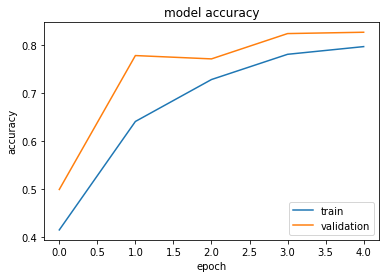

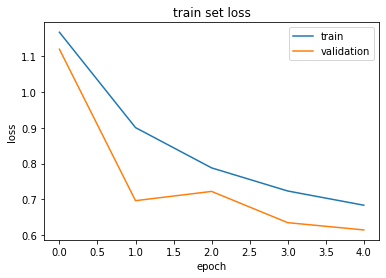

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [35]:
test_gen.reset()
predY=model.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

915/915 [==============================] - 25s 26ms/step


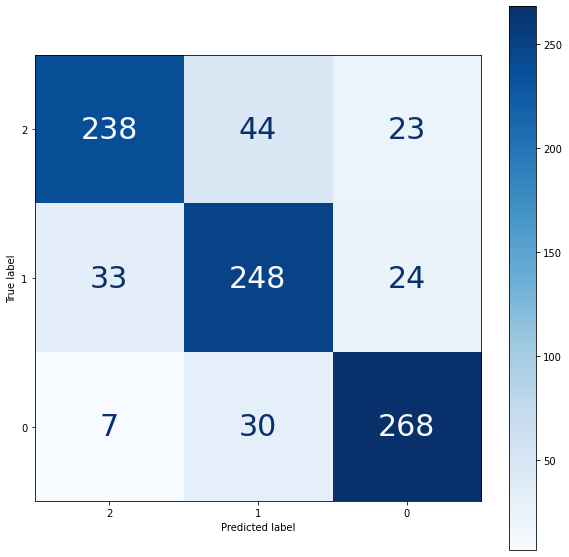

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

# Let's print classification report

<AxesSubplot:>

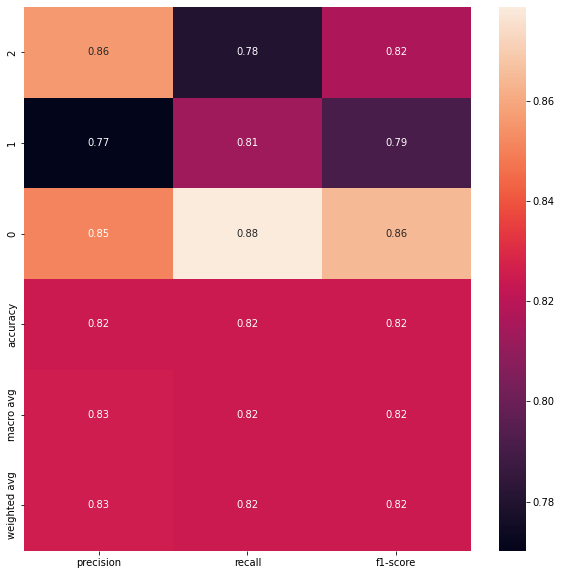

In [37]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, ax=ax)

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'larger')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize = 'larger')
        plt.yticks(tick_marks, target_names, fontsize = 'larger')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "blue", fontsize = 'larger')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "blue", fontsize = 'larger')


    plt.tight_layout()
    plt.ylabel('True label', fontsize = 'larger')
    plt.xlabel('Predicted label', fontsize = 'larger')

    plt.show()


# **Now let's try Stratified K-Fold for training**

In [131]:
train_path = '/kaggle/working/out/train'
test_path = '/kaggle/working/out/test'

image_size = 224
batch_size = 16
n_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 20

patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8

In [132]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = ViT( 3,6,(224//6)**2,64,4,8,2,0.1)
    
model.compile(optimizer = optimizer, 
                loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
                metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                ],
                )

In [133]:
from sklearn.model_selection import StratifiedKFold

In [134]:
Y = df_train[['class']]

skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

Function to save the model at each 'k'th iteration

In [135]:
histories = []
time_list = []

def New_Model(fold_var):
    
    STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
    STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
    STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                     min_delta = 1e-4,
                                                     patience = 5,
                                                     mode = 'max',
                                                     restore_best_weights = True,
                                                     verbose = 1)

    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_' + str(fold_var) + '.hdf5',
                                                      monitor = 'val_accuracy', 
                                                      verbose = 1,
                                                      save_best_only=True,
                                                      mode = 'max')
    
    callbacks = [earlystopping, lr_scheduler, checkpointer]
    
    startTrain = time()
    history = model.fit(x = train_gen,
              steps_per_epoch = STEP_SIZE_TRAIN,
              validation_data = valid_gen,
              validation_steps = STEP_SIZE_VALID,
              epochs = num_epochs,
              callbacks = callbacks)
    time_list.append(time()-startTrain)
    

    # store history for each folds
    histories.append(history)
    
    tf.keras.backend.clear_session()

In [136]:
fold_var = 1

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        featurewise_center=False,  # set input mean to 0 over the dataset
                                                        samplewise_center=False,  # set each sample mean to 0
                                                        featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                                        samplewise_std_normalization=False,  # divide each input by its std
                                                        zca_whitening=False,  # apply ZCA whitening
                                                        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
                                                        zoom_range = 0.1, # Randomly zoom image 
                                                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                                        horizontal_flip=True)  # randomly flip images)  



for train_index, val_index in skf.split(np.zeros(len(Y)),Y):
    training_data = df_train.iloc[train_index]
    validation_data = df_train.iloc[val_index]

    train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                            directory = train_path,
                                            x_col = 'directory',
                                            y_col = 'class',
                                            subset = 'training',
                                            batch_size = batch_size,
                                            seed = 1,
                                            color_mode = 'rgb',
                                            shuffle = True,
                                            class_mode = 'categorical',
                                            target_size = (image_size, image_size))

    valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                            directory = train_path,
                                            x_col = 'directory',
                                            y_col = 'class',
                                            subset = 'validation',
                                            batch_size = batch_size,
                                            seed = 1,
                                            color_mode = 'rgb',
                                            shuffle = True,
                                            class_mode = 'categorical',
                                            target_size = (image_size, image_size))
    print(); print("#"*50)
    print("Fold: ",f+1)
    print("#"*50)

    New_Model(fold_var)
    fold_var += 1


Found 3660 validated image filenames belonging to 3 classes.
Found 0 validated image filenames belonging to 3 classes.
Epoch 1/20
228/228 [==============================] - 120s 487ms/step - loss: 1.1921 - accuracy: 0.4094 - top-5-accuracy: 1.0000
Epoch 2/20
228/228 [==============================] - 112s 488ms/step - loss: 0.9713 - accuracy: 0.5697 - top-5-accuracy: 1.0000
Epoch 3/20
228/228 [==============================] - 112s 491ms/step - loss: 0.8929 - accuracy: 0.6249 - top-5-accuracy: 1.0000
Epoch 4/20
228/228 [==============================] - 112s 489ms/step - loss: 0.8486 - accuracy: 0.6636 - top-5-accuracy: 1.0000
Epoch 5/20
228/228 [==============================] - 111s 487ms/step - loss: 0.8029 - accuracy: 0.7080 - top-5-accuracy: 1.0000
Epoch 6/20
228/228 [==============================] - 112s 489ms/step - loss: 0.7540 - accuracy: 0.7371 - top-5-accuracy: 1.0000
Epoch 7/20
228/228 [==============================] - 112s 490ms/step - loss: 0.7398 - accuracy: 0.7536 - t

# Running time & memory occupation(complexity) of the model

In [ ]:
print("Trainable parameters: ",model.count_params() )
print("Running time: ",sum(time_list))

In [137]:
test_gen = ImageDataGenerator(rescale=1/255.0) # just rescaling for test data


test_gen = datagen.flow_from_directory(
    directory=r"./out/test/",
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=1,
    target_size = (image_size, image_size)
)

Found 915 images belonging to 3 classes.


In [158]:
model.metrics_names

['loss', 'accuracy', 'top-5-accuracy']

In [163]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}
test_gen.reset()
predY=model.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
print(predY)
testY = test_gen.classes
confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4))
print (cr)
print(confusion__matrix)

915/915 [==============================] - 29s 31ms/step
[[0.9190074  0.04986462 0.03112794]
 [0.96014076 0.02122579 0.01863342]
 [0.93559986 0.03435332 0.03004677]
 ...
 [0.0725451  0.04494065 0.8825142 ]
 [0.06974545 0.04103411 0.8892205 ]
 [0.0710538  0.03159928 0.8973469 ]]
{'pneumonia': {'precision': 0.8375350140056023, 'recall': 0.980327868852459, 'f1-score': 0.9033232628398793, 'support': 305}, 'covid': {'precision': 0.8992805755395683, 'recall': 0.819672131147541, 'f1-score': 0.8576329331046312, 'support': 305}, 'normal': {'precision': 0.975, 'recall': 0.8950819672131147, 'f1-score': 0.9333333333333332, 'support': 305}, 'accuracy': 0.898360655737705, 'macro avg': {'precision': 0.9039385298483902, 'recall': 0.898360655737705, 'f1-score': 0.8980965097592812, 'support': 915}, 'weighted avg': {'precision': 0.9039385298483902, 'recall': 0.898360655737705, 'f1-score': 0.8980965097592811, 'support': 915}}
[[299   4   2]
 [ 50 250   5]
 [  8  24 273]]


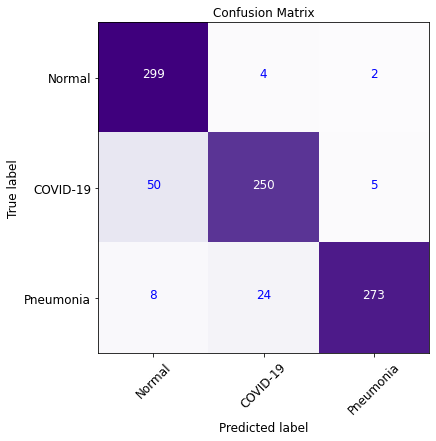

In [164]:
plot_confusion_matrix(confusion__matrix, 
                      normalize = False,
                      target_names = ['Normal', 'COVID-19', 'Pneumonia'],
                      title        = "Confusion Matrix")

# **GRAD Cam**

https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see#kln-48

In [80]:
model.summary()

Model: "vi_t"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_embedding (PatchEmbedd multiple                  94720     
_________________________________________________________________
transformer_encoder (Transfo multiple                  267776    
_________________________________________________________________
sequential_10 (Sequential)   (None, 3)                 8707      
Total params: 371,203
Trainable params: 371,203
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.layers[-1].summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 8,707
Trainable params: 8,707
Non-trainable params: 0
_________________________________________________________________


In [89]:
for idx in range(len(model.layers)):
    print(model.get_layer(index = idx).name)

patch_embedding
transformer_encoder
sequential_10


In [86]:
from tensorflow.keras.models import Sequential, Model

def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-6].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

SyntaxError: invalid syntax (2642156106.py, line 3)

In [67]:
import matplotlib.cm as cm

In [68]:
df_test

,directory,class
357,pneumonia/person1308_bacteria_3280.jpeg,pneumonia
1969,covid/COVID-19 (305).jpg,covid
3734,normal/00000211_033.png,normal
4374,normal/00000169_001.png,normal
2825,covid/COVID19(226).jpg,covid
...,...,...
3279,normal/00000741_008.png,normal
2357,covid/COVID-19 (637).jpg,covid
520,pneumonia/person401_virus_797.jpeg,pneumonia
572,pneumonia/person1220_virus_2068.jpeg,pneumonia


In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img_size = 224

In [70]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img


In [71]:
def gradCAMImage(image):
    path = f"/kaggle/working/out/test/{image}"
    img = readImage(path)
    img = tf.image.resize(img,[299,299])
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [72]:
def gradcam_of_images(correct_class):
    grad_images = []
    temp_df = df_test
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.directory[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)

    return grad_images

In [83]:
correctly_classified = gradcam_of_images(correct_class=True)

AttributeError: Layer vi_t has no inbound nodes.

In [ ]:
def display_heatmaps(classified_images):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
    plt.show()

In [ ]:
display_heatmaps(correctly_classified)